# NOTE: CODE NEEDS TO BE RUN IN ORDER

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import f_regression, mutual_info_regression 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import ensemble

In [2]:
housing = pd.read_csv('./data/Ames_HousePrice.csv', index_col=0)
housing['PricePerGLA'] = housing['SalePrice'] / housing['GrLivArea']
pd.set_option('display.max_columns', housing.shape[1])
addl_features = pd.read_csv('./data/data3_sub_w_nnprice.csv')[['PID', 'nn5meanprice', 'nn5medprice']]
housing = pd.merge(housing, addl_features, on = 'PID')
housing.sample(10)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,PricePerGLA,nn5meanprice,nn5medprice
2071,535402140,1651,172000,80,RL,93.0,10090,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,SLvl,7,5,1963,1999,Gable,CompShg,Plywood,Plywood,BrkFace,364.0,TA,TA,CBlock,TA,TA,Av,Rec,242.0,ALQ,483.0,0.0,725.0,...,Y,SBrkr,1035,616,0,0.0,1.0,2,0,4,1,TA,6,Typ,2,TA,BuiltIn,1963.0,Unf,1.0,276.0,TA,TA,Y,460,46,0,0,165,0,NaN,MnPrv,NaN,0,10,2007,WD,Normal,104.179285,123.601601,125.874126
620,528218060,1456,170440,60,RL,65.0,10237,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,RRAn,Norm,1Fam,2Story,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,728.0,728.0,...,Y,SBrkr,728,728,0,0.0,0.0,2,1,3,1,Gd,8,Typ,1,Gd,Attchd,2005.0,Fin,2.0,390.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,2,2006,New,Partial,117.060440,117.691114,115.339506
226,533120030,2810,302000,60,RL,NaN,9572,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,1990,1990,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,336.0,Gd,TA,PConc,Ex,TA,No,GLQ,482.0,Unf,0.0,971.0,1453.0,...,Y,SBrkr,1453,1357,0,0.0,0.0,2,1,4,1,Gd,9,Typ,1,Ex,Attchd,1990.0,RFn,2.0,750.0,Gd,Gd,Y,500,0,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,107.473310,124.374561,118.188252
144,527131030,1659,278000,120,RL,40.0,5664,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,2000,2000,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,1158.0,Unf,0.0,343.0,1501.0,...,Y,SBrkr,1659,0,0,1.0,0.0,2,0,2,1,Ex,5,Typ,1,Ex,Attchd,2000.0,Fin,2.0,499.0,TA,TA,Y,212,59,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,167.570826,157.985938,151.937046
2485,916326010,1707,228000,20,RL,NaN,16669,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,1Story,8,6,1981,1981,Hip,WdShake,Plywood,Plywood,BrkFace,653.0,Gd,TA,CBlock,Gd,TA,No,Unf,0.0,Unf,0.0,1686.0,1686.0,...,Y,SBrkr,1707,0,0,0.0,0.0,2,1,2,1,TA,6,Typ,1,TA,Attchd,1981.0,RFn,2.0,511.0,TA,TA,Y,574,64,0,0,0,0,NaN,NaN,NaN,0,1,2006,WD,Normal,133.567663,129.172725,128.012048
2471,907135040,1097,145000,20,RL,112.0,10859,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1097.0,1097.0,...,Y,SBrkr,1097,0,0,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1995.0,Unf,2.0,672.0,TA,TA,Y,392,64,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,132.178669,143.473120,146.464646
1399,905426100,2008,225000,20,RL,78.0,7800,Pave,NaN,Reg,Bnk,AllPub,Inside,Mod,Edwards,Norm,Norm,1Fam,2Story,5,8,1948,2002,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,Gd,No,GLQ,603.0,Unf,0.0,293.0,896.0,...,Y,SBrkr,1112,896,0,1.0,0.0,3,0,3,1,Ex,8,Typ,0,NaN,Attchd,1948.0,Unf,1.0,230.0,TA,TA,Y,103,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD,Normal,112.051793,128.157725,114.784206
1154,902300215,1416,153900,50,RM,100.0,12665,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,5,8,1915,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,Mn,Unf,0.0,Unf,0.0,876.0,876.0,...,Y,SBrkr,876,540,0,0.0,0.0,1,1,4,1,TA,7,Typ,1,Gd,Detchd,1949.0,Unf,3.0,720.0,TA,TA,Y,418,0,194,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,108.686441,87.045950,87.669683
2079,908186060,1072,145000,180,RM,35.0,3675,Pave,NaN,Reg,Lvl,A

In [3]:
def dummify(dataframe, column):
    """Dummifies the given column in the given dataframe and drops the class with the highest frequency of occurence. 
    Returns the original dataframe with the given column dropped and dummified columns added"""
    temp = pd.get_dummies(dataframe[~dataframe[column].isnull()][column], prefix = column)
    temp.drop(column + '_' + str(dataframe[~dataframe[column].isnull()][column].mode()[0]), axis = 1, inplace = True)
    dataframe = dataframe[~dataframe[column].isnull()].drop(column, axis = 1)
    dataframe = pd.concat([dataframe, temp], axis = 1)
    return dataframe

# Initial Features Selection Based On Qualitative EDA

In [4]:
# Primary: (MSSubClass, HouseStyle, BldgType), MsZoning, LandContour, LotConfig, Neighborhood, Condition1, YearBuilt, 
# YearRemodAdd (binary categorical variable of 1 or 0 on remodeling), RoofStyle, (Exterior1st, Exterior2nd, 
# MasVnrType, ExterQual, ExterCond), Foundation, (BsmtQual, BsmtCond, BsmtFinType1, BsmtFinSF1, TotalBsmtSF), HeatingQC, 
# CentralAir, Electrical, (1stFlrSF, 2ndFlrSF), (BsmtFullBath, FullBath, HalfBath), (BedroomAbvGr, TotRmsAbvGrd), 
# (KitchenAbvGr, KitchenQual), (GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond,
# PavedDrive), MoSold, SaleType, SaleCondition

# Features After Unary F-tests and Mutual Information

In [4]:
label_encoder = LabelEncoder()
housing_temp = housing.copy()
housing_temp.drop(['PID', 'SalePrice', 'LotFrontage'], axis = 1, inplace= True)

housing_temp['YearRemodAdd'] = (housing_temp['YearBuilt'] != housing_temp['YearRemodAdd']).map(int)

cat_features_with_NA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                   'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for feature in cat_features_with_NA:
    housing_temp[feature].fillna('NA', inplace = True)
housing_temp = housing_temp[~housing_temp.isnull().any(axis = 1)]

features_to_be_dummified = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
                            'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
                            'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                            'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                            'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
                            'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                            'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
for column in features_to_be_dummified:
    housing_temp = dummify(housing_temp, column)

value_f, p_f = f_regression(housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'], housing_temp['PricePerGLA'])
mutual_scores = mutual_info_regression(housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'],
                                       housing_temp['PricePerGLA'])

In [5]:
p_values = pd.Series(p_f, index = housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'].columns).sort_values()
p_values.head(25)

nn5meanprice            7.037008e-280
nn5medprice             3.193762e-258
YearBuilt               1.229616e-173
BsmtFinSF1              3.878930e-137
GarageYrBlt             2.680716e-133
TotalBsmtSF             4.371840e-132
BsmtQual_Ex             8.465298e-101
BsmtFullBath             1.806311e-91
2ndFlrSF                 5.571787e-88
BedroomAbvGr             4.314049e-85
ExterQual_Ex             7.294728e-76
KitchenQual_Ex           2.084936e-74
BsmtExposure_Gd          3.806575e-70
OverallQual_9            1.876975e-68
GarageArea               2.225151e-67
GarageCars               3.535205e-61
HouseStyle_1.5Fin        1.526582e-59
1stFlrSF                 1.122326e-58
Neighborhood_NridgHt     5.440332e-58
GarageType_Detchd        1.930976e-52
MSSubClass_50            3.770088e-52
ExterQual_Gd             1.249285e-51
MSZoning_RM              1.322184e-49
OverallQual_8            1.824660e-43
Foundation_BrkTil        2.949967e-42
dtype: float64

In [6]:
mutual_score_values = pd.Series(mutual_scores, 
        index = housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'].columns).sort_values(ascending = False)
mutual_score_values.head(25)

nn5medprice          0.322106
nn5meanprice         0.318586
YearBuilt            0.266448
GarageYrBlt          0.212648
2ndFlrSF             0.199817
TotalBsmtSF          0.198369
BsmtFinSF1           0.191626
1stFlrSF             0.143031
GrLivArea            0.117323
BedroomAbvGr         0.099787
BsmtUnfSF            0.089877
BsmtFullBath         0.087043
BsmtQual_Ex          0.085421
GarageArea           0.085337
TotRmsAbvGrd         0.078270
HouseStyle_1.5Fin    0.076247
GarageCars           0.073652
MSSubClass_50        0.071866
BsmtQual_Gd          0.071413
MasVnrArea           0.068950
HouseStyle_2Story    0.067947
ExterQual_Gd         0.066857
LotArea              0.064755
GarageType_Detchd    0.061017
OverallQual_9        0.060770
dtype: float64

# Features After Comparing R2 From Simple Linear Regression 

In [8]:
# Test R2 > 0.1: MsSubClass, HouseStyle, MSZoning, Neighborhood, YearBuilt, ExterQual, Foundation, BsmtQual, BsmtFinType1, 
#                BsmtFinSF1, TotalBsmtSF, BsmtFullBath, BedroomAbvGr, KitchenQual, GarageType, GarageYrBlt, GarageFinish,
#                GarageCars, nn5medprice, nn5meanprice

In [9]:
# Test R2 > 0.15: MsSubClass, HouseStyle, Neighborhood, YearBuilt, ExterQual, Foundation, BsmtQual, BsmtFinType1, 
#                BsmtFinSF1, TotalBsmtSF, BsmtFullBath, BedroomAbvGr, KitchenQual, GarageYrBlt, GarageCars, nn5medprice,
#                nn5meanprice

In [10]:
# Test R2 > 0.2: MsSubClass, HouseStyle, Neighborhood, YearBuilt, ExterQual, BsmtQual, BsmtFinType1, KitchenQual,
#               GarageYrBlt, nn5medprice, nn5meanprice

# Features After Feature Selection from Random Forest 

In [7]:
label_encoder = LabelEncoder()
housing_temp = housing.copy()
housing_temp.drop(['PID', 'SalePrice', 'LotFrontage'], axis = 1, inplace= True)

housing_temp['YearRemodAdd'] = (housing_temp['YearBuilt'] != housing_temp['YearRemodAdd']).map(int)

cat_features_with_NA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                   'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for feature in cat_features_with_NA:
    housing_temp[feature].fillna('NA', inplace = True)
housing_temp = housing_temp[~housing_temp.isnull().any(axis = 1)]

features_to_be_encoded = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
                          'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                          'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                          'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                          'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
                          'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                          'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
for feature in features_to_be_encoded:
    housing_temp[feature] = label_encoder.fit_transform(housing_temp[feature])

housing_temp.reset_index(inplace = True)
housing_temp.drop('index', axis = 1, inplace = True)
train_idx = np.random.choice(range(housing_temp.shape[0]), round(0.7 * housing_temp.shape[0]), replace = False)
test_idx = housing_temp.index[~housing_temp.index.isin(train_idx)]
housing_temp_train = housing_temp.iloc[train_idx, :]
housing_temp_test = housing_temp.iloc[test_idx, :]

randomForest = ensemble.RandomForestRegressor()

grid_para_forest = [{
    "n_estimators": [50, 100, 150],
    "criterion": ["mse"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start = 10, stop = 30, num = 5, dtype = int),
    "random_state": [42]}]

grid_search_forest = GridSearchCV(randomForest, grid_para_forest, cv = 5, n_jobs = -1)
grid_search_forest.fit(housing_temp_train.loc[:, housing_temp_train.columns != 'PricePerGLA'],
                       housing_temp_train['PricePerGLA'])

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['mse'],
                          'min_samples_leaf': range(1, 10),
                          'min_samples_split': array([10, 15, 20, 25, 30]),
                          'n_estimators': [50, 100, 150],
                          'random_state': [42]}])

In [8]:
grid_search_forest.best_params_

{'criterion': 'mse',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 150,
 'random_state': 42}

In [9]:
grid_search_forest.score(housing_temp_test.loc[:, housing_temp_test.columns != 'PricePerGLA'], 
                         housing_temp_test['PricePerGLA'])

0.7902696546869088

In [10]:
feature_importance = list(zip(housing_temp.columns[housing_temp.columns != 'PricePerGLA'],
                              grid_search_forest.best_estimator_.feature_importances_))
pd.DataFrame(sorted(feature_importance, key = lambda x: x[1], reverse = True), columns = ['feature', 'importance']).head(25)

,feature,importance
0,nn5meanprice,0.269521
1,2ndFlrSF,0.139692
2,nn5medprice,0.076619
3,OverallQual,0.073126
4,YearBuilt,0.049979
5,BsmtFinType1,0.045046
6,GrLivArea,0.033606
7,OverallCond,0.032806
8,ExterQual,0.025795
9,BsmtFinSF1,0.024803


# Best Features Based on Initial Qualitative EDA, Comparing R2, Unary F-tests, and Mutual Information

In [15]:
# MSSubClass_50, HouseStyle_1.5Fin, Neighborhood_NridgHt, YearBuilt, ExterQual_Gd, Foundation_BrkTil, BsmtQual_Ex, 
# BsmtFinSF1, TotalBsmtSF, BsmtFullBath, BedroomAbvGr, KitchenQual_Ex, GarageYrBlt, GarageCars, GarageArea, nn5meanprice,
# nn5medprice

In [11]:
housing_temp = housing[['MSSubClass', 'HouseStyle', 'Neighborhood', 'YearBuilt', 'ExterQual', 'Foundation', 'BsmtQual', 
                        'BsmtFinSF1', 'TotalBsmtSF', 'BsmtFullBath', 'BedroomAbvGr', 'KitchenQual', 'GarageYrBlt', 
                        'GarageCars', 'GarageArea', 'nn5medprice', 'nn5meanprice', 'PricePerGLA']].copy()

housing_temp['MSSubClass'] = housing_temp['MSSubClass'] == 50
housing_temp['HouseStyle'] = housing_temp['HouseStyle'] == '1.5Fin'
housing_temp['Neighborhood'] = housing_temp['Neighborhood'] == 'NridgHt'
housing_temp['ExterQual'] = housing_temp['ExterQual'] == 'Gd'
housing_temp['Foundation'] = housing_temp['Foundation'] == 'BrkTil'
housing_temp['BsmtQual'] = housing_temp['BsmtQual'] == 'Ex'
housing_temp['KitchenQual'] = housing_temp['KitchenQual'] == 'Ex'

housing_temp = housing_temp[~housing_temp.isnull().any(axis = 1)].reset_index().drop('index', axis = 1)

In [12]:
regression = LinearRegression()
k5 = KFold(n_splits=5)
train_R2 = []
test_R2 = []

for train_index, test_index in k5.split(housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'], 
                                        housing_temp['PricePerGLA']):
    x_train = housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'].iloc[train_index]
    y_train = housing_temp['PricePerGLA'][train_index]
    x_test = housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'].iloc[test_index]
    y_test = housing_temp['PricePerGLA'][test_index]
    regression.fit(x_train, y_train)
    train_R2.append(regression.score(x_train, y_train))
    test_R2.append(regression.score(x_test, y_test))

print(f'Train R2: {np.array(train_R2).mean(): .3}')
print(f'Test R2: {np.array(test_R2).mean(): .3}')

Train R2:  0.645
Test R2:  0.633


# Lasso Penalization

In [13]:
scaler = StandardScaler()
data = housing_temp[['YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF', 'BsmtFullBath', 'BedroomAbvGr', 'GarageYrBlt', 'GarageCars',
                     'GarageArea', 'nn5medprice', 'nn5meanprice']].copy()
scaler.fit(data)
scaled_data = pd.DataFrame(scaler.transform(data), columns = data.columns)
housing_temp = pd.concat([scaled_data, housing_temp[['MSSubClass', 'HouseStyle', 'Neighborhood', 'ExterQual', 'Foundation',
                                                     'BsmtQual', 'KitchenQual', 'PricePerGLA']]], axis = 1)

lasso  = Lasso()
alphas = np.linspace(0.5, 10, 20)
lasso.set_params(normalize = False)
coefs_lasso  = []

for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'], housing_temp['PricePerGLA'])  
    coefs_lasso.append(lasso.coef_)

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, 
                           columns = housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'].columns)  
coefs_lasso

,YearBuilt,BsmtFinSF1,TotalBsmtSF,BsmtFullBath,BedroomAbvGr,GarageYrBlt,GarageCars,GarageArea,nn5medprice,nn5meanprice,MSSubClass,HouseStyle,Neighborhood,ExterQual,Foundation,BsmtQual,KitchenQual
0.5,2.952102,4.512615,3.910912,1.930733,-9.010459,1.699363,0.0,0.215715,2.229467,7.885263,-0.0,-1.557642,0.0,0.0,-0.0,3.610485,4.103894
1.0,2.825276,4.621087,4.022395,1.730042,-8.561099,1.644296,0.0,0.177781,1.748385,8.864865,-0.0,-0.000000,0.0,0.0,-0.0,0.000000,0.000000
1.5,2.746096,4.541101,3.788596,1.524170,-8.082329,1.468794,0.0,0.000000,1.554127,9.024365,-0.0,-0.000000,0.0,0.0,-0.0,0.000000,0.000000
2.0,2.713513,4.450109,3.506962,1.315945,-7.630231,1.187028,0.0,0.000000,1.344580,9.175892,-0.0,-0.000000,0.0,0.0,-0.0,0.000000,0.000000
2.5,2.680966,4.359129,3.225315,1.107719,-7.178119,0.905248,0.0,0.000000,1.135858,9.326619,-0.0,-0.000000,0.0,0.0,-0.0,0.000000,0.000000
3.0,2.648383,4.268136,2.943681,0.899494,-6.726021,0.623482,0.0,0.000000,0.926295,9.478160,-0.0,-0.000000,0.0,0.0,-0.0,0.000000,0.000000
3.5,2.615801,4.177144,2.662047,0.691270,-6.273922,0.341715,0.0,0.000000,0.716733,9.629702,-0.0,-0.000000,0.0,0.0,-0.0,0.000000,0.000000
4.0,2.583218,4.086152,2.380413,0.483045,-5.821824,0.059949,0.0,0.000000,0.507171,9.781243,-0.0,-0.000000,0.0,0.0,-0.0,0.000000,0.000000
4.5,2.371331,4.006494,2.094797,0.274572,-5.369893,0.000000,0.0,0.000000,0.289133,9.928116,-0.0,-0.000000,0.0,0.0,-0.0,0.000000,0.000000
5.0,2.111014,3.929900,1.808110,0.066032,-4.918009,0.000000,0.0,0.000000,0.068866,10.073645,-0.0,-0.000000,0.0,0.0,-0.0,0.000000,0.000000


In [19]:
# Drop GarageCars since coefficients drop off faster vs. GarageArea
# Drop GarageYrBlt since coefficients drop off faster vs. YearBuilt
# Drop nn5medprice since coefficients drop off faster vs. nn5meanprice
# Drop TotalBsmtSF since coefficients drop off faster vs. BsmtFinSF1

# Multicollinearity for Continuous Features

In [14]:
continuous_features = ['YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF', 'GarageYrBlt', 'GarageArea', 'nn5medprice', 'nn5meanprice']
scores = {}
ols = LinearRegression()
for feature in continuous_features:
    housing_temp = housing[~housing[continuous_features].isnull().any(axis = 1)][continuous_features].copy()
    feature_col = housing_temp[feature].copy()
    housing_temp.drop(feature, axis=1, inplace=True)
    ols.fit(housing_temp, feature_col)
    scores[feature] = ols.score(housing_temp, feature_col)   

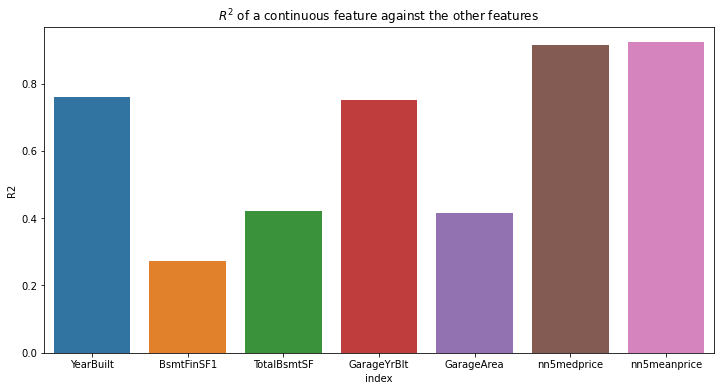

In [15]:
plt.figure(figsize = (12, 6))
sns.barplot(x='index', y='R2', data=pd.DataFrame(scores, index=['R2']).T.reset_index())
plt.title('$R^2$ of a continuous feature against the other features');

In [22]:
# Drop GarageYrBlt since its R2, p-value for F-test, and mutual information score is worse than YearBuilt. Lasso also
# suggests its less important than YearBuilt.
# Drop nn5medprice since its R2, p-value for F-test, and mutual information score is slightly worse than nn5meanprice. 
# Lasso also suggests its less important than nn5meanprice.
# Drop TotalBsmtSF since correlation vs. other features is higher than BsmtFinSF1

# --- Final Regression ---

In [16]:
housing_temp = housing[['MSSubClass', 'HouseStyle', 'Neighborhood', 'YearBuilt', 'ExterQual', 'Foundation', 'BsmtQual', 
                        'BsmtFinSF1', 'BsmtFullBath', 'BedroomAbvGr', 'KitchenQual', 'GarageArea', 'nn5meanprice',
                        'PricePerGLA']].copy()


housing_temp['MSSubClass'] = housing_temp['MSSubClass'] == 50
housing_temp['HouseStyle'] = housing_temp['HouseStyle'] == '1.5Fin'
housing_temp['Neighborhood'] = housing_temp['Neighborhood'] == 'NridgHt'
housing_temp['ExterQual'] = housing_temp['ExterQual'] == 'Gd'
housing_temp['Foundation'] = housing_temp['Foundation'] == 'BrkTil'
housing_temp['BsmtQual'] = housing_temp['BsmtQual'] == 'Ex'
housing_temp['KitchenQual'] = housing_temp['KitchenQual'] == 'Ex'

housing_temp = housing_temp[~housing_temp.isnull().any(axis = 1)].reset_index().drop('index', axis = 1)

In [17]:
regression = LinearRegression()
k5 = KFold(n_splits=5)
train_R2 = []
test_R2 = []

for train_index, test_index in k5.split(housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'], 
                                        housing_temp['PricePerGLA']):
    x_train = housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'].iloc[train_index]
    y_train = housing_temp['PricePerGLA'][train_index]
    x_test = housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'].iloc[test_index]
    y_test = housing_temp['PricePerGLA'][test_index]
    regression.fit(x_train, y_train)
    train_R2.append(regression.score(x_train, y_train))
    test_R2.append(regression.score(x_test, y_test))

print(f'Train R2: {np.array(train_R2).mean(): .3}')
print(f'Test R2: {np.array(test_R2).mean(): .3}')

Train R2:  0.64
Test R2:  0.632


In [20]:
regression.fit(housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'], housing_temp['PricePerGLA'])
print('R2: %.3f'%regression.score(housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'], housing_temp['PricePerGLA']))
pd.concat([pd.DataFrame({'features': housing_temp.columns[:-1].values, 'coefficients': regression.coef_}), 
           pd.DataFrame({'features': ['Intercept'], 'coefficients': regression.intercept_})], axis = 0).reset_index().drop('index', axis = 1)

R2: 0.640


,features,coefficients
0,MSSubClass,8.569943
1,HouseStyle,-14.888581
2,Neighborhood,0.401028
3,YearBuilt,0.151021
4,ExterQual,0.668634
5,Foundation,0.662332
6,BsmtQual,9.285984
7,BsmtFinSF1,0.013146
8,BsmtFullBath,3.799012
9,BedroomAbvGr,-11.400639


# APPENDIX: R2 CALCULATION FOR EACH FEATURE FROM INITIAL QUALITATIVE EDA

# nn5medprice

In [25]:
housing_temp = housing[~housing['nn5medprice'].isnull()][['PricePerGLA', 'nn5medprice']]
housing_temp

,PricePerGLA,nn5medprice
0,147.196262,87.774295
1,132.983794,99.408284
2,124.775225,65.393093
3,109.720885,120.694444
4,136.336336,120.274914
...,...,...
2555,127.100840,88.902980
2556,80.553953,130.434783
2557,72.427572,91.082317
2558,118.078176,117.469880


In [26]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.383
Test R2: 0.413


# nn5meanprice

In [27]:
housing_temp = housing[~housing['nn5meanprice'].isnull()][['PricePerGLA', 'nn5meanprice']]
housing_temp

,PricePerGLA,nn5meanprice
0,147.196262,90.569952
1,132.983794,120.315223
2,124.775225,72.928680
3,109.720885,124.945633
4,136.336336,119.003791
...,...,...
2555,127.100840,93.312424
2556,80.553953,127.856188
2557,72.427572,96.250071
2558,118.078176,119.542978


In [28]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.405
Test R2: 0.456


# MSSubClass

In [29]:
MSSubClass = pd.get_dummies(housing['MSSubClass'], prefix = 'MSSubClass')
MSSubClass.drop('MSSubClass_' + str(housing['MSSubClass'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], MSSubClass], axis = 1)
housing_temp

,PricePerGLA,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,147.196262,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,132.983794,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,124.775225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,109.720885,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,136.336336,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,127.100840,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2556,80.553953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2557,72.427572,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2558,118.078176,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.390
Test R2: 0.387


# HouseStyle

In [31]:
HouseStyle = pd.get_dummies(housing['HouseStyle'], prefix = 'HouseStyle')
HouseStyle.drop('HouseStyle_' + str(housing['HouseStyle'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], HouseStyle], axis = 1)
housing_temp

,PricePerGLA,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl
0,147.196262,0,0,0,0,0,0,0
1,132.983794,0,0,0,0,0,0,0
2,124.775225,0,0,0,0,0,0,0
3,109.720885,0,0,0,0,1,0,0
4,136.336336,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
2555,127.100840,0,1,0,0,0,0,0
2556,80.553953,0,0,0,0,0,0,0
2557,72.427572,0,0,0,0,1,0,0
2558,118.078176,0,0,0,0,1,0,0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.259
Test R2: 0.247


# BldgType

In [33]:
BldgType = pd.get_dummies(housing['BldgType'], prefix = 'BldgType')
BldgType.drop('BldgType_' + str(housing['BldgType'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], BldgType], axis = 1)
housing_temp

,PricePerGLA,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE
0,147.196262,0,0,0,0
1,132.983794,0,0,0,1
2,124.775225,0,0,0,0
3,109.720885,0,0,0,0
4,136.336336,0,0,0,0
...,...,...,...,...,...
2555,127.100840,0,0,0,0
2556,80.553953,0,0,0,0
2557,72.427572,0,1,0,0
2558,118.078176,0,0,0,0


In [34]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.106
Test R2: 0.086


# MSZoning

In [35]:
MSZoning = pd.get_dummies(housing['MSZoning'], prefix = 'MSZoning')
MSZoning.drop('MSZoning_' + str(housing['MSZoning'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], MSZoning], axis = 1)
housing_temp

,PricePerGLA,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RM
0,147.196262,0,0,0,0,0
1,132.983794,0,0,0,0,0
2,124.775225,1,0,0,0,0
3,109.720885,0,0,0,0,0
4,136.336336,0,0,0,0,0
...,...,...,...,...,...,...
2555,127.100840,0,0,0,0,0
2556,80.553953,0,0,0,0,0
2557,72.427572,0,0,0,1,0
2558,118.078176,0,0,0,0,0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.131
Test R2: 0.094


# LandContour

In [37]:
LandContour = pd.get_dummies(housing['LandContour'], prefix = 'LandContour')
LandContour.drop('LandContour_' + str(housing['LandContour'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], LandContour], axis = 1)
housing_temp

,PricePerGLA,LandContour_Bnk,LandContour_HLS,LandContour_Low
0,147.196262,0,0,0
1,132.983794,0,0,0
2,124.775225,0,0,0
3,109.720885,0,0,0
4,136.336336,0,0,0
...,...,...,...,...
2555,127.100840,0,0,0
2556,80.553953,0,0,0
2557,72.427572,0,1,0
2558,118.078176,0,0,0


In [38]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.031
Test R2: 0.061


# LotConfig

In [39]:
LotConfig = pd.get_dummies(housing['LotConfig'], prefix = 'LotConfig')
LotConfig.drop('LotConfig_' + str(housing['LotConfig'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], LotConfig], axis = 1)
housing_temp

,PricePerGLA,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3
0,147.196262,1,0,0,0
1,132.983794,0,0,0,0
2,124.775225,0,0,0,0
3,109.720885,1,0,0,0
4,136.336336,0,0,0,0
...,...,...,...,...,...
2555,127.100840,0,0,0,0
2556,80.553953,0,1,0,0
2557,72.427572,0,0,0,0
2558,118.078176,0,0,0,0


In [40]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.012
Test R2: 0.020


# Neighborhood

In [41]:
Neighborhood = pd.get_dummies(housing['Neighborhood'], prefix = 'Neighborhood')
Neighborhood.drop('Neighborhood_' + str(housing['Neighborhood'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], Neighborhood], axis = 1)
housing_temp

,PricePerGLA,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,147.196262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,132.983794,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,124.775225,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,109.720885,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,136.336336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,127.100840,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2556,80.553953,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2557,72.427572,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2558,118.078176,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.389
Test R2: 0.364


# Condition1

In [43]:
Condition1 = pd.get_dummies(housing['Condition1'], prefix = 'Condition1')
Condition1.drop('Condition1_' + str(housing['Condition1'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], Condition1], axis = 1)
housing_temp

,PricePerGLA,Condition1_Artery,Condition1_Feedr,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn
0,147.196262,0,0,0,0,0,0,0,0
1,132.983794,0,0,0,0,0,0,0,0
2,124.775225,0,0,0,0,0,0,0,0
3,109.720885,0,0,0,0,0,0,0,0
4,136.336336,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2555,127.100840,0,0,0,0,0,0,0,0
2556,80.553953,0,0,0,0,0,0,0,0
2557,72.427572,0,0,0,0,0,0,0,0
2558,118.078176,0,0,0,0,0,0,0,0


In [44]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.046
Test R2: 0.047


# YearBuilt

In [45]:
housing_temp = housing[['PricePerGLA', 'YearBuilt']]
housing_temp

,PricePerGLA,YearBuilt
0,147.196262,1939
1,132.983794,1984
2,124.775225,1930
3,109.720885,1900
4,136.336336,2001
...,...,...
2555,127.100840,1916
2556,80.553953,1955
2557,72.427572,1949
2558,118.078176,2000


In [46]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.298
Test R2: 0.295


# YearRemodAdd

In [47]:
housing_temp = housing.copy()
housing_temp['Remod'] = (housing_temp['YearBuilt'] != housing_temp['YearRemodAdd']).map(int)
housing_temp = housing_temp[['PricePerGLA', 'Remod']]
housing_temp

,PricePerGLA,Remod
0,147.196262,1
1,132.983794,0
2,124.775225,1
3,109.720885,1
4,136.336336,0
...,...,...
2555,127.100840,1
2556,80.553953,0
2557,72.427572,1
2558,118.078176,0


In [48]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.032
Test R2: 0.033


# RoofStyle

In [49]:
RoofStyle = pd.get_dummies(housing['RoofStyle'], prefix = 'RoofStyle')
RoofStyle.drop('RoofStyle_' + str(housing['RoofStyle'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], RoofStyle], axis = 1)
housing_temp

,PricePerGLA,RoofStyle_Flat,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
0,147.196262,0,0,0,0,0
1,132.983794,0,0,0,0,0
2,124.775225,0,0,1,0,0
3,109.720885,0,0,0,0,0
4,136.336336,0,0,0,0,0
...,...,...,...,...,...,...
2555,127.100840,0,0,0,0,0
2556,80.553953,0,0,1,0,0
2557,72.427572,0,0,0,0,0
2558,118.078176,0,0,0,0,0


In [50]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.047
Test R2: 0.051


# Exterior1st, Exterior2nd

In [51]:
housing_temp = housing.copy()
housing_temp['Exterior2nd'].replace('Brk Cmn', 'BrkComm', inplace = True)
housing_temp['Exterior2nd'].replace('CmentBd', 'CemntBd', inplace = True)
housing_temp['Exterior2nd'].replace('Wd Shng', 'WdShing', inplace= True)
housing_temp['Exterior'] = housing_temp['Exterior1st'] + '_' + housing_temp['Exterior2nd'] 
housing_temp = housing_temp[['PricePerGLA', 'Exterior']]
Exterior = pd.get_dummies(housing_temp['Exterior'], prefix = 'Exterior')
Exterior.drop('Exterior_' + str(housing_temp['Exterior'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], Exterior], axis = 1)
housing_temp

,PricePerGLA,Exterior_AsbShng_AsbShng,Exterior_AsbShng_CemntBd,Exterior_AsbShng_Plywood,Exterior_AsbShng_Stucco,Exterior_AsbShng_Wd Sdng,Exterior_AsphShn_AsphShn,Exterior_BrkComm_BrkComm,Exterior_BrkComm_Stucco,Exterior_BrkComm_Wd Sdng,Exterior_BrkFace_AsbShng,Exterior_BrkFace_BrkFace,Exterior_BrkFace_HdBoard,Exterior_BrkFace_MetalSd,Exterior_BrkFace_Plywood,Exterior_BrkFace_Stone,Exterior_BrkFace_Stucco,Exterior_BrkFace_Wd Sdng,Exterior_CBlock_CBlock,Exterior_CemntBd_CemntBd,Exterior_CemntBd_Wd Sdng,Exterior_CemntBd_WdShing,Exterior_HdBoard_AsphShn,Exterior_HdBoard_BrkFace,Exterior_HdBoard_HdBoard,Exterior_HdBoard_ImStucc,Exterior_HdBoard_MetalSd,Exterior_HdBoard_Plywood,Exterior_HdBoard_Stucco,Exterior_HdBoard_Wd Sdng,Exterior_HdBoard_WdShing,Exterior_ImStucc_ImStucc,Exterior_MetalSd_AsphShn,Exterior_MetalSd_CBlock,Exterior_MetalSd_HdBoard,Exterior_MetalSd_MetalSd,Exterior_MetalSd_Stucco,Exterior_MetalSd_VinylSd,Exterior_MetalSd_Wd Sdng,Exterior_MetalSd_WdShing,Exterior_Plywood_BrkComm,Exterior_Plywood_CBlock,Exterior_Plywood_HdBoard,Exterior_Plywood_ImStucc,Exterior_Plywood_Plywood,Exterior_Plywood_VinylSd,Exterior_Plywood_Wd Sdng,Exterior_Plywood_WdShing,Exterior_PreCast_PreCast,Exterior_Stucco_BrkFace,Exterior_Stucco_CemntBd,Exterior_Stucco_Plywood,Exterior_Stucco_Stone,Exterior_Stucco_Stucco,Exterior_Stucco_Wd Sdng,Exterior_Stucco_WdShing,Exterior_VinylSd_AsbShng,Exterior_VinylSd_HdBoard,Exterior_VinylSd_ImStucc,Exterior_VinylSd_MetalSd,Exterior_VinylSd_Plywood,Exterior_VinylSd_Wd Sdng,Exterior_VinylSd_WdShing,Exterior_Wd Sdng_AsbShng,Exterior_Wd Sdng_BrkFace,Exterior_Wd Sdng_HdBoard,Exterior_Wd Sdng_ImStucc,Exterior_Wd Sdng_MetalSd,Exterior_Wd Sdng_Plywood,Exterior_Wd Sdng_Stucco,Exterior_Wd Sdng_VinylSd,Exterior_Wd Sdng_Wd Sdng,Exterior_Wd Sdng_WdShing,Exterior_WdShing_HdBoard,Exterior_WdShing_Plywood,Exterior_WdShing_Stucco,Exterior_WdShing_Wd Sdng,Exterior_WdShing_WdShing
0,147.196262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,132.983794,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,124.775225,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,109.720885,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,136.336336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,127.100840,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2556,80.553953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2557,72.427572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2558,118.078176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.112
Test R2:-14601081626076272853516288.000


# MasVnrType

In [53]:
MasVnrType = pd.get_dummies(housing[~housing['MasVnrType'].isnull()]['MasVnrType'], prefix = 'MasVnrType')
MasVnrType.drop('MasVnrType_' + str(housing[~housing['MasVnrType'].isnull()]['MasVnrType'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['MasVnrType'].isnull()]['PricePerGLA'], MasVnrType], axis = 1)
housing_temp

,PricePerGLA,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone
0,147.196262,0,0,0
1,132.983794,0,1,0
2,124.775225,0,0,0
3,109.720885,0,0,0
4,136.336336,0,0,0
...,...,...,...,...
2555,127.100840,0,0,0
2556,80.553953,0,0,0
2557,72.427572,0,0,0
2558,118.078176,0,1,0


In [54]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.074
Test R2: 0.113


# ExterQual

In [55]:
ExterQual = pd.get_dummies(housing['ExterQual'], prefix = 'ExterQual')
ExterQual.drop('ExterQual_' + str(housing['ExterQual'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], ExterQual], axis = 1)
housing_temp

,PricePerGLA,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd
0,147.196262,0,0,0
1,132.983794,0,0,1
2,124.775225,0,0,1
3,109.720885,0,0,1
4,136.336336,0,0,1
...,...,...,...,...
2555,127.100840,0,0,0
2556,80.553953,0,0,0
2557,72.427572,0,0,0
2558,118.078176,0,0,1


In [56]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.250
Test R2: 0.265


# ExterCond

In [57]:
ExterCond = pd.get_dummies(housing['ExterCond'], prefix = 'ExterCond')
ExterCond.drop('ExterCond_' + str(housing['ExterCond'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], ExterCond], axis = 1)
housing_temp

,PricePerGLA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po
0,147.196262,0,0,0,0
1,132.983794,0,0,0,0
2,124.775225,0,0,0,0
3,109.720885,0,0,1,0
4,136.336336,0,0,0,0
...,...,...,...,...,...
2555,127.100840,0,0,0,0
2556,80.553953,0,0,0,0
2557,72.427572,0,0,0,0
2558,118.078176,0,0,0,0


In [58]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.035
Test R2: 0.023


# Foundation

In [59]:
Foundation = pd.get_dummies(housing['Foundation'], prefix = 'Foundation')
Foundation.drop('Foundation_' + str(housing['Foundation'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], Foundation], axis = 1)
housing_temp

,PricePerGLA,Foundation_BrkTil,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood
0,147.196262,0,0,0,0,0
1,132.983794,0,0,0,0,0
2,124.775225,1,0,0,0,0
3,109.720885,1,0,0,0,0
4,136.336336,0,1,0,0,0
...,...,...,...,...,...,...
2555,127.100840,1,0,0,0,0
2556,80.553953,0,0,1,0,0
2557,72.427572,0,0,0,0,0
2558,118.078176,0,1,0,0,0


In [60]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.181
Test R2: 0.169


# BsmtQual

In [61]:
BsmtQual = pd.get_dummies(housing[~housing['BsmtQual'].isnull()]['BsmtQual'], prefix = 'BsmtQual')
BsmtQual.drop('BsmtQual_' + str(housing[~housing['BsmtQual'].isnull()]['BsmtQual'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['BsmtQual'].isnull()]['PricePerGLA'], BsmtQual], axis = 1)
housing_temp

,PricePerGLA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Po
0,147.196262,0,0,0,0
1,132.983794,0,0,1,0
2,124.775225,0,0,0,0
3,109.720885,0,1,0,0
4,136.336336,0,0,1,0
...,...,...,...,...,...
2554,113.979118,0,0,1,0
2555,127.100840,0,0,0,0
2557,72.427572,0,0,0,0
2558,118.078176,0,0,1,0


In [62]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.268
Test R2: 0.281


# BsmtCond

In [63]:
BsmtCond = pd.get_dummies(housing[~housing['BsmtCond'].isnull()]['BsmtCond'], prefix = 'BsmtCond')
BsmtCond.drop('BsmtCond_' + str(housing[~housing['BsmtCond'].isnull()]['BsmtCond'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['BsmtCond'].isnull()]['PricePerGLA'], BsmtCond], axis = 1)
housing_temp

,PricePerGLA,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po
0,147.196262,0,0,0,0
1,132.983794,0,0,0,0
2,124.775225,0,0,0,0
3,109.720885,0,0,0,0
4,136.336336,0,0,0,0
...,...,...,...,...,...
2554,113.979118,0,0,0,0
2555,127.100840,0,0,0,0
2557,72.427572,0,0,0,0
2558,118.078176,0,0,0,0


In [64]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.049
Test R2: 0.044


# BsmtFinType1

In [65]:
BsmtFinType1 = pd.get_dummies(housing[~housing['BsmtFinType1'].isnull()]['BsmtFinType1'], prefix = 'BsmtFinType1')
BsmtFinType1.drop('BsmtFinType1_' + str(housing[~housing['BsmtFinType1'].isnull()]['BsmtFinType1'].mode()[0]),
                  axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['BsmtFinType1'].isnull()]['PricePerGLA'], BsmtFinType1], axis = 1)
housing_temp

,PricePerGLA,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf
0,147.196262,0,0,0,1,0
1,132.983794,0,0,0,0,0
2,124.775225,1,0,0,0,0
3,109.720885,0,0,0,0,1
4,136.336336,0,0,0,0,0
...,...,...,...,...,...,...
2554,113.979118,0,0,0,0,1
2555,127.100840,0,0,0,0,1
2557,72.427572,0,1,0,0,0
2558,118.078176,0,0,0,0,0


In [66]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.244
Test R2: 0.263


# BsmtFinSF1

In [67]:
housing_temp = housing[(~housing['BsmtFinSF1'].isnull()) & housing['BsmtFinSF1'] != 0][['PricePerGLA', 'BsmtFinSF1']]
housing_temp

,PricePerGLA,BsmtFinSF1
0,147.196262,238.0
1,132.983794,552.0
2,124.775225,737.0
4,136.336336,643.0
8,154.668166,647.0
...,...,...
2551,129.213483,890.0
2553,159.068627,574.0
2557,72.427572,284.0
2558,118.078176,841.0


In [68]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.197
Test R2: 0.151


# TotalBsmtSF

In [69]:
housing_temp = housing[(~housing['TotalBsmtSF'].isnull()) & housing['TotalBsmtSF'] != 0][['PricePerGLA', 'TotalBsmtSF']]
housing_temp

,PricePerGLA,TotalBsmtSF
0,147.196262,856.0
1,132.983794,1049.0
2,124.775225,837.0
3,109.720885,405.0
4,136.336336,810.0
...,...,...
2554,113.979118,796.0
2555,127.100840,952.0
2557,72.427572,1001.0
2558,118.078176,985.0


In [70]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.161
Test R2: 0.247


# HeatingQC

In [71]:
HeatingQC = pd.get_dummies(housing['HeatingQC'], prefix = 'HeatingQC')
HeatingQC.drop('HeatingQC_' + str(housing['HeatingQC'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], HeatingQC], axis = 1)
housing_temp

,PricePerGLA,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA
0,147.196262,0,0,0,1
1,132.983794,0,0,0,1
2,124.775225,0,0,0,0
3,109.720885,0,1,0,0
4,136.336336,0,0,0,0
...,...,...,...,...,...
2555,127.100840,1,0,0,0
2556,80.553953,0,0,0,0
2557,72.427572,0,0,0,1
2558,118.078176,0,0,0,0


In [72]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.117
Test R2: 0.098


# CentralAir

In [73]:
housing_temp = housing.copy()
housing_temp['CentralAir'] = (housing_temp['CentralAir'] == 'Y').map(int)
housing_temp = housing_temp[['PricePerGLA', 'CentralAir']]
housing_temp

,PricePerGLA,CentralAir
0,147.196262,1
1,132.983794,1
2,124.775225,1
3,109.720885,1
4,136.336336,1
...,...,...
2555,127.100840,0
2556,80.553953,1
2557,72.427572,0
2558,118.078176,1


In [74]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.078
Test R2: 0.084


# Electrical

In [75]:
Electrical = pd.get_dummies(housing[~housing['Electrical'].isnull()]['Electrical'], prefix = 'Electrical')
Electrical.drop('Electrical_' + str(housing[~housing['Electrical'].isnull()]['Electrical'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['Electrical'].isnull()]['PricePerGLA'], Electrical], axis = 1)
housing_temp

,PricePerGLA,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP
0,147.196262,0,0,0
1,132.983794,0,0,0
2,124.775225,0,0,0
3,109.720885,0,0,0
4,136.336336,0,0,0
...,...,...,...,...
2555,127.100840,0,1,0
2556,80.553953,1,0,0
2557,72.427572,1,0,0
2558,118.078176,0,0,0


In [76]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.061
Test R2: 0.043


# 1stFlrSF

In [77]:
housing_temp = housing[['PricePerGLA', '1stFlrSF']]
housing_temp

,PricePerGLA,1stFlrSF
0,147.196262,856
1,132.983794,1049
2,124.775225,1001
3,109.720885,717
4,136.336336,810
...,...,...
2555,127.100840,952
2556,80.553953,1733
2557,72.427572,1001
2558,118.078176,985


In [78]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.096
Test R2: 0.092


# 2ndFlrSF

In [79]:
housing_temp = housing[housing['2ndFlrSF'] != 0][['PricePerGLA', '2ndFlrSF']]
housing_temp

,PricePerGLA,2ndFlrSF
3,109.720885,322
4,136.336336,855
5,103.277836,1427
11,106.750392,650
15,97.023810,794
...,...,...
2549,112.530414,683
2554,113.979118,918
2557,72.427572,1001
2558,118.078176,857


In [80]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.036
Test R2: 0.020


# BsmtFullBath

In [81]:
BsmtFullBath = pd.get_dummies(housing[~housing['BsmtFullBath'].isnull()]['BsmtFullBath'], prefix = 'BsmtFullBath')
BsmtFullBath.drop('BsmtFullBath_' + str(housing[~housing['BsmtFullBath'].isnull()]['BsmtFullBath'].mode()[0]),
                  axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['BsmtFullBath'].isnull()]['PricePerGLA'], BsmtFullBath], axis = 1)
housing_temp

,PricePerGLA,BsmtFullBath_1.0,BsmtFullBath_2.0,BsmtFullBath_3.0
0,147.196262,1,0,0
1,132.983794,1,0,0
2,124.775225,0,0,0
3,109.720885,0,0,0
4,136.336336,1,0,0
...,...,...,...,...
2555,127.100840,0,0,0
2556,80.553953,0,0,0
2557,72.427572,0,0,0
2558,118.078176,1,0,0


In [82]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.144
Test R2: 0.184


# FullBath

In [83]:
FullBath = pd.get_dummies(housing['FullBath'], prefix = 'FullBath')
FullBath.drop('FullBath_' + str(housing['FullBath'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], FullBath], axis = 1)
housing_temp

,PricePerGLA,FullBath_0,FullBath_1,FullBath_3,FullBath_4
0,147.196262,0,1,0,0
1,132.983794,0,0,0,0
2,124.775225,0,1,0,0
3,109.720885,0,1,0,0
4,136.336336,0,0,0,0
...,...,...,...,...,...
2555,127.100840,0,1,0,0
2556,80.553953,0,0,0,0
2557,72.427572,0,0,0,0
2558,118.078176,0,0,0,0


In [84]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.009
Test R2: 0.009


# HalfBath

In [85]:
HalfBath = pd.get_dummies(housing['HalfBath'], prefix = 'HalfBath')
HalfBath.drop('HalfBath_' + str(housing['HalfBath'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], HalfBath], axis = 1)
housing_temp

,PricePerGLA,HalfBath_1,HalfBath_2
0,147.196262,0,0
1,132.983794,0,0
2,124.775225,0,0
3,109.720885,0,0
4,136.336336,1,0
...,...,...,...
2555,127.100840,0,0
2556,80.553953,0,0
2557,72.427572,0,0
2558,118.078176,1,0


In [86]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.027
Test R2: 0.008


# BedroomAbvGr

In [87]:
BedroomAbvGr = pd.get_dummies(housing['BedroomAbvGr'], prefix = 'BedroomAbvGr')
BedroomAbvGr.drop('BedroomAbvGr_' + str(housing['BedroomAbvGr'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], BedroomAbvGr], axis = 1)
housing_temp

,PricePerGLA,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6
0,147.196262,0,0,1,0,0,0
1,132.983794,0,0,1,0,0,0
2,124.775225,0,0,1,0,0,0
3,109.720885,0,0,1,0,0,0
4,136.336336,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2555,127.100840,0,0,1,0,0,0
2556,80.553953,0,0,0,1,0,0
2557,72.427572,0,0,0,1,0,0
2558,118.078176,0,0,0,0,0,0


In [88]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.173
Test R2: 0.124


# TotRmsAbvGrd

In [89]:
TotRmsAbvGrd = pd.get_dummies(housing['TotRmsAbvGrd'], prefix = 'TotRmsAbvGrd')
TotRmsAbvGrd.drop('TotRmsAbvGrd_' + str(housing['TotRmsAbvGrd'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], TotRmsAbvGrd], axis = 1)
housing_temp

,PricePerGLA,TotRmsAbvGrd_2,TotRmsAbvGrd_3,TotRmsAbvGrd_4,TotRmsAbvGrd_5,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_13
0,147.196262,0,0,1,0,0,0,0,0,0,0,0
1,132.983794,0,0,0,1,0,0,0,0,0,0,0
2,124.775225,0,0,0,1,0,0,0,0,0,0,0
3,109.720885,0,0,0,0,0,0,0,0,0,0,0
4,136.336336,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2555,127.100840,0,0,1,0,0,0,0,0,0,0,0
2556,80.553953,0,0,0,0,0,1,0,0,0,0,0
2557,72.427572,0,0,0,0,0,1,0,0,0,0,0
2558,118.078176,0,0,0,0,1,0,0,0,0,0,0


In [90]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.061
Test R2: 0.029


# KitchenAbvGr

In [91]:
KitchenAbvGr = pd.get_dummies(housing['KitchenAbvGr'], prefix = 'KitchenAbvGr')
KitchenAbvGr.drop('KitchenAbvGr_' + str(housing['KitchenAbvGr'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], KitchenAbvGr], axis = 1)
housing_temp

,PricePerGLA,KitchenAbvGr_0,KitchenAbvGr_2,KitchenAbvGr_3
0,147.196262,0,0,0
1,132.983794,0,0,0
2,124.775225,0,0,0
3,109.720885,0,0,0
4,136.336336,0,0,0
...,...,...,...,...
2555,127.100840,0,0,0
2556,80.553953,0,0,0
2557,72.427572,0,1,0
2558,118.078176,0,0,0


In [92]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.086
Test R2: 0.092


# KitchenQual

In [93]:
KitchenQual = pd.get_dummies(housing['KitchenQual'], prefix = 'KitchenQual')
KitchenQual.drop('KitchenQual_' + str(housing['KitchenQual'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], KitchenQual], axis = 1)
housing_temp

,PricePerGLA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po
0,147.196262,0,0,0,0
1,132.983794,0,0,1,0
2,124.775225,0,0,1,0
3,109.720885,0,0,0,0
4,136.336336,0,0,1,0
...,...,...,...,...,...
2555,127.100840,0,1,0,0
2556,80.553953,0,0,0,0
2557,72.427572,0,0,0,0
2558,118.078176,0,0,1,0


In [94]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.226
Test R2: 0.208


# Fireplaces

In [95]:
Fireplaces = pd.get_dummies(housing['Fireplaces'], prefix = 'Fireplaces')
Fireplaces.drop('Fireplaces_' + str(housing['Fireplaces'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], Fireplaces], axis = 1)
housing_temp

,PricePerGLA,Fireplaces_1,Fireplaces_2,Fireplaces_3,Fireplaces_4
0,147.196262,1,0,0,0
1,132.983794,0,0,0,0
2,124.775225,0,0,0,0
3,109.720885,0,0,0,0
4,136.336336,0,0,0,0
...,...,...,...,...,...
2555,127.100840,1,0,0,0
2556,80.553953,1,0,0,0
2557,72.427572,0,0,0,0
2558,118.078176,1,0,0,0


In [96]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.037
Test R2: 0.019


# GarageType

In [97]:
GarageType = pd.get_dummies(housing[~housing['GarageType'].isnull()]['GarageType'], prefix = 'GarageType')
GarageType.drop('GarageType_' + str(housing[~housing['GarageType'].isnull()]['GarageType'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageType'].isnull()]['PricePerGLA'], GarageType], axis = 1)
housing_temp

,PricePerGLA,GarageType_2Types,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,147.196262,0,0,0,0,1
1,132.983794,0,0,0,0,0
2,124.775225,0,0,0,0,1
3,109.720885,0,0,0,0,1
4,136.336336,0,0,0,0,0
...,...,...,...,...,...,...
2555,127.100840,0,0,0,0,1
2556,80.553953,0,0,0,0,0
2557,72.427572,1,0,0,0,0
2558,118.078176,0,0,0,0,0


In [98]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.125
Test R2: 0.103


# GarageYrBlt

In [99]:
housing_temp = housing[(~housing['GarageYrBlt'].isnull()) & (housing['GarageYrBlt'] != 0)][['PricePerGLA', 'GarageYrBlt']]
housing_temp

,PricePerGLA,GarageYrBlt
0,147.196262,1939.0
1,132.983794,1984.0
2,124.775225,1930.0
3,109.720885,1940.0
4,136.336336,2001.0
...,...,...
2555,127.100840,1916.0
2556,80.553953,1955.0
2557,72.427572,1949.0
2558,118.078176,2000.0


In [100]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.232
Test R2: 0.202


# GarageFinish

In [101]:
GarageFinish = pd.get_dummies(housing[~housing['GarageFinish'].isnull()]['GarageFinish'], prefix = 'GarageFinish')
GarageFinish.drop('GarageFinish_' + str(housing[~housing['GarageFinish'].isnull()]['GarageFinish'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageFinish'].isnull()]['PricePerGLA'], GarageFinish], axis = 1)
housing_temp

,PricePerGLA,GarageFinish_Fin,GarageFinish_RFn
0,147.196262,0,0
1,132.983794,1,0
2,124.775225,0,0
3,109.720885,0,0
4,136.336336,1,0
...,...,...,...
2555,127.100840,0,0
2556,80.553953,0,0
2557,72.427572,0,0
2558,118.078176,1,0


In [102]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.151
Test R2: 0.059


# GarageCars

In [103]:
GarageCars = pd.get_dummies(housing[~housing['GarageCars'].isnull()]['GarageCars'], prefix = 'GarageCars')
GarageCars.drop('GarageCars_' + str(housing[~housing['GarageCars'].isnull()]['GarageCars'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageCars'].isnull()]['PricePerGLA'], GarageCars], axis = 1)
housing_temp

,PricePerGLA,GarageCars_0.0,GarageCars_1.0,GarageCars_3.0,GarageCars_4.0,GarageCars_5.0
0,147.196262,0,0,0,0,0
1,132.983794,0,1,0,0,0
2,124.775225,0,1,0,0,0
3,109.720885,0,1,0,0,0
4,136.336336,0,0,0,0,0
...,...,...,...,...,...,...
2555,127.100840,0,1,0,0,0
2556,80.553953,0,0,0,0,0
2557,72.427572,0,0,1,0,0
2558,118.078176,0,0,0,0,0


In [104]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.170
Test R2: 0.151


# GarageArea

In [105]:
housing_temp = housing[(~housing['GarageArea'].isnull()) & (housing['GarageArea'] != 0)][['PricePerGLA', 'GarageArea']]
housing_temp

,PricePerGLA,GarageArea
0,147.196262,399.0
1,132.983794,266.0
2,124.775225,216.0
3,109.720885,281.0
4,136.336336,528.0
...,...,...
2555,127.100840,192.0
2556,80.553953,452.0
2557,72.427572,871.0
2558,118.078176,486.0


In [106]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.135
Test R2: 0.075


# GarageQual

In [107]:
GarageQual = pd.get_dummies(housing[~housing['GarageQual'].isnull()]['GarageQual'], prefix = 'GarageQual')
GarageQual.drop('GarageQual_' + str(housing[~housing['GarageQual'].isnull()]['GarageQual'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageQual'].isnull()]['PricePerGLA'], GarageQual], axis = 1)
housing_temp

,PricePerGLA,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po
0,147.196262,0,0,0,0
1,132.983794,0,0,0,0
2,124.775225,0,0,0,0
3,109.720885,0,0,0,0
4,136.336336,0,0,0,0
...,...,...,...,...,...
2555,127.100840,0,1,0,0
2556,80.553953,0,0,0,0
2557,72.427572,0,0,0,0
2558,118.078176,0,0,0,0


In [108]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.042
Test R2: 0.031


# GarageCond

In [109]:
GarageCond = pd.get_dummies(housing[~housing['GarageCond'].isnull()]['GarageCond'], prefix = 'GarageCond')
GarageCond.drop('GarageCond_' + str(housing[~housing['GarageCond'].isnull()]['GarageCond'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageCond'].isnull()]['PricePerGLA'], GarageCond], axis = 1)
housing_temp

,PricePerGLA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po
0,147.196262,0,0,0,0
1,132.983794,0,0,0,0
2,124.775225,0,0,0,1
3,109.720885,0,0,0,0
4,136.336336,0,0,0,0
...,...,...,...,...,...
2555,127.100840,0,0,0,1
2556,80.553953,0,0,0,0
2557,72.427572,0,0,0,0
2558,118.078176,0,0,0,0


In [110]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.041
Test R2: 0.049


# PavedDrive

In [111]:
PavedDrive = pd.get_dummies(housing['PavedDrive'], prefix = 'PavedDrive')
PavedDrive.drop('PavedDrive_' + str(housing['PavedDrive'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], PavedDrive], axis = 1)
housing_temp

,PricePerGLA,PavedDrive_N,PavedDrive_P
0,147.196262,0,0
1,132.983794,0,0
2,124.775225,1,0
3,109.720885,1,0
4,136.336336,0,0
...,...,...,...
2555,127.100840,0,1
2556,80.553953,0,0
2557,72.427572,0,0
2558,118.078176,0,0


In [112]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.089
Test R2: 0.070


# MoSold

In [113]:
MoSold = pd.get_dummies(housing['MoSold'], prefix = 'MoSold')
MoSold.drop('MoSold_' + str(housing['MoSold'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], MoSold], axis = 1)
housing_temp

,PricePerGLA,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12
0,147.196262,0,0,1,0,0,0,0,0,0,0,0
1,132.983794,0,1,0,0,0,0,0,0,0,0,0
2,124.775225,0,0,0,0,0,0,0,0,0,1,0
3,109.720885,0,0,0,0,1,0,0,0,0,0,0
4,136.336336,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2555,127.100840,0,0,0,0,1,0,0,0,0,0,0
2556,80.553953,0,0,0,0,0,0,0,0,0,0,0
2557,72.427572,0,0,0,0,0,0,1,0,0,0,0
2558,118.078176,0,0,0,0,0,1,0,0,0,0,0


In [114]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.004
Test R2:-0.007


# SaleType

In [115]:
SaleType = pd.get_dummies(housing['SaleType'], prefix = 'SaleType')
SaleType.drop('SaleType_' + str(housing['SaleType'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], SaleType], axis = 1)
housing_temp

,PricePerGLA,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD
0,147.196262,0,0,0,0,0,0,0,0,0
1,132.983794,0,0,0,0,0,0,0,0,0
2,124.775225,0,0,0,0,0,0,0,0,0
3,109.720885,0,0,0,0,0,0,0,0,0
4,136.336336,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2555,127.100840,0,0,0,0,0,0,0,0,0
2556,80.553953,0,0,0,0,0,0,0,0,0
2557,72.427572,0,0,0,0,0,0,0,0,0
2558,118.078176,0,0,0,0,0,0,0,0,0


In [116]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.078
Test R2: 0.035


# SaleCondition

In [117]:
SaleCondition = pd.get_dummies(housing['SaleCondition'], prefix = 'SaleCondition')
SaleCondition.drop('SaleCondition_' + str(housing['SaleCondition'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], SaleCondition], axis = 1)
housing_temp

,PricePerGLA,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial
0,147.196262,0,0,0,0,0
1,132.983794,0,0,0,0,0
2,124.775225,0,0,0,0,0
3,109.720885,0,0,0,0,0
4,136.336336,0,0,0,0,0
...,...,...,...,...,...,...
2555,127.100840,0,0,0,0,0
2556,80.553953,0,0,0,0,0
2557,72.427572,0,0,0,0,0
2558,118.078176,0,0,0,0,0


In [118]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.077
Test R2: 0.038
